Starting Training on FrozenLake-v1...
Episode: 500/5000 | Avg Reward (last 100): 0.6600 | Success Rate: 66.00% | Epsilon: 0.0100
Episode: 1000/5000 | Avg Reward (last 100): 0.6800 | Success Rate: 68.00% | Epsilon: 0.0100
Episode: 1500/5000 | Avg Reward (last 100): 0.4600 | Success Rate: 46.00% | Epsilon: 0.0100
Episode: 2000/5000 | Avg Reward (last 100): 0.4800 | Success Rate: 48.00% | Epsilon: 0.0100
Episode: 2500/5000 | Avg Reward (last 100): 0.3300 | Success Rate: 33.00% | Epsilon: 0.0100
Episode: 3000/5000 | Avg Reward (last 100): 0.4800 | Success Rate: 48.00% | Epsilon: 0.0100
Episode: 3500/5000 | Avg Reward (last 100): 0.5400 | Success Rate: 54.00% | Epsilon: 0.0100
Episode: 4000/5000 | Avg Reward (last 100): 0.4000 | Success Rate: 40.00% | Epsilon: 0.0100
Episode: 4500/5000 | Avg Reward (last 100): 0.5600 | Success Rate: 56.00% | Epsilon: 0.0100
Episode: 5000/5000 | Avg Reward (last 100): 0.7100 | Success Rate: 71.00% | Epsilon: 0.0100
Training complete.


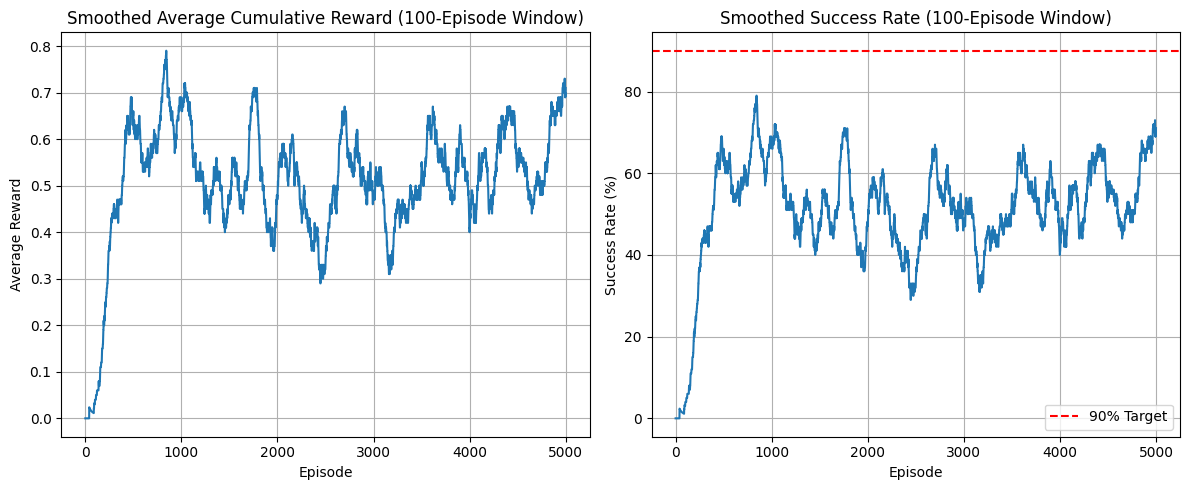


Learned Optimal Policy (Direction to take in each state):
---------------------------------------
| ← | ← | ← | ← |
| ← | ↓ | ← | ← |
| ↑ | ↓ | ← | ← |
| ↓ | → | ↓ | ↓ |
---------------------------------------
Legend: S=Start, F=Frozen, H=Hole, G=Goal.


In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION AND HYPERPARAMETERS ---
# Based on the proposal's requirements for low computational overhead
ENV_NAME = 'FrozenLake-v1'
# The 4x4 map is 16 states. We set is_slippery=True to match the "Stochastic" dynamics.
# render_mode="rgb_array" is needed for visualization if running non-headless,
# but for a simple grid, "ansi" is sufficient for print output in a notebook.
env = gym.make(ENV_NAME, is_slippery=True)

# DRL Hyperparameters
GAMMA = 0.99            # Discount factor (gamma in the proposal)
LEARNING_RATE = 1e-3    # Alpha (α) in the proposal
MEMORY_SIZE = 10000     # Maximum size of the replay buffer
BATCH_SIZE = 64         # Size of the experience batch for training
EPS_START = 1.0         # Initial exploration rate (epsilon in the proposal)
EPS_END = 0.01          # Minimum exploration rate
EPS_DECAY = 0.999       # Decay rate per step
TARGET_UPDATE = 100     # Frequency (in steps) to update the target network

# Training Parameters
NUM_EPISODES = 5000     # Total episodes for training
MAX_STEPS_PER_EPISODE = 200

# Torch setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. DQN ARCHITECTURE (DQN Network) ---
# A simple fully connected network as defined in the proposal (Page 5, Section 4.A)
class DQN(nn.Module):
    """Deep Q-Network architecture for discrete state/action spaces."""
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()

        # FrozenLake uses a Discrete state space (e.g., 16).
        # We will treat this as a one-hot encoded vector for the input layer.
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        # Output layer size equals the number of possible actions (4)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        # The state is received as a one-hot encoded tensor
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        # The output are the Q-values for each action
        return self.fc3(x)

# --- 3. REPLAY BUFFER (DQN Key Mechanism) ---
# Stores experience tuples for off-policy learning
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    """A circular buffer to store experience transitions."""
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Saves a transition (s, a, r, s', done)."""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Retrieves a random batch of transitions."""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# --- 4. THE AGENT CLASS ---
class DQNAgent:
    """Manages the main policy and target networks, and the training loop."""
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = EPS_START
        self.memory = ReplayBuffer(MEMORY_SIZE)
        self.steps_done = 0

        # Initialize two networks: Policy Network (Q) and Target Network (Q_target)
        self.policy_net = DQN(state_size, action_size).to(device)
        self.target_net = DQN(state_size, action_size).to(device)
        # Copy initial weights from policy to target
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval() # Set target network to evaluation mode

        # Optimizer and Loss Function
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.criterion = nn.MSELoss()

    # Utility: Convert discrete state ID to one-hot vector for network input
    def _to_one_hot(self, state):
        vector = np.zeros(self.state_size, dtype=np.float32)
        vector[state] = 1.0
        return torch.tensor(vector).unsqueeze(0).to(device)

    def select_action(self, state):
        """
        Implements the epsilon-greedy policy (Page 5, Section 4.B).
        Decays epsilon based on steps taken.
        """
        sample = random.random()

        # Decay epsilon for the next step
        self.epsilon = max(EPS_END, self.epsilon * EPS_DECAY)
        self.steps_done += 1

        if sample > self.epsilon:
            # Exploitation: Choose the action with the highest Q-value
            with torch.no_grad():
                state_tensor = self._to_one_hot(state)
                # policy_net(state_tensor) returns Q-values for all actions
                return self.policy_net(state_tensor).argmax(1).item()
        else:
            # Exploration: Choose a random action
            return env.action_space.sample()

    def optimize_model(self):
        """Performs one step of optimization on the policy network."""
        if len(self.memory) < BATCH_SIZE:
            return

        # Sample a batch from the replay memory
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        # Separate components into tensors
        state_batch = torch.cat([self._to_one_hot(s) for s in batch.state]).to(device)
        action_batch = torch.tensor(batch.action).unsqueeze(1).to(device)
        reward_batch = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
        non_final_next_states = torch.cat([self._to_one_hot(s) for s in batch.next_state if s is not None]).to(device)
        # Create a mask for non-final states
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),
                                      dtype=torch.bool).to(device)

        # 1. Compute Q(s_t, a_t): Q-values for the actions taken
        # policy_net(state_batch) gives Q(s, a) for all 'a'. .gather picks the Q-value for the action taken 'a_t'.
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # 2. Compute V(s_{t+1}) = max_a Q_target(s_{t+1}, a)
        # Initialize next_state_values to 0.0 (for terminal states)
        next_state_values = torch.zeros(BATCH_SIZE, 1, device=device)

        # Use target_net to calculate the maximum Q-value for non-terminal next states
        with torch.no_grad():
            max_q_next = self.target_net(non_final_next_states).max(1)[0].unsqueeze(1)
            next_state_values[non_final_mask] = max_q_next

        # 3. Compute the Expected Q-values (Target): r + gamma * V(s_{t+1})
        expected_state_action_values = reward_batch + (GAMMA * next_state_values)

        # Compute loss (MSE between predicted Q and target Q)
        loss = self.criterion(state_action_values, expected_state_action_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # Optional: Clip gradients to prevent exploding gradients
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def update_target_net(self):
        """Updates the target network weights every TARGET_UPDATE steps."""
        self.target_net.load_state_dict(self.policy_net.state_dict())


# --- 5. MAIN TRAINING LOOP ---

# Initialize agent
state_space_size = env.observation_space.n  # 16 or 64
action_space_size = env.action_space.n      # 4 (Left, Down, Right, Up)
agent = DQNAgent(state_space_size, action_space_size)

# Logging lists
episode_rewards = []
episode_successes = []
smoothed_rewards = []
smoothed_successes = []
print(f"Starting Training on {ENV_NAME}...")

# Training
for episode in range(NUM_EPISODES):
    # Reset environment for a new episode
    state, _ = env.reset()
    total_reward = 0
    success = False

    for t in range(MAX_STEPS_PER_EPISODE):
        # Agent selects an action
        action = agent.select_action(state)

        # Environment takes a step
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Sparse reward:
        # The default FrozenLake rewards +1 only on reaching the goal ('G').
        # Add experience to replay memory
        # next_state is None if terminal (done=True)
        agent.memory.push(state, action, reward, next_state if not done else None, done)

        state = next_state
        total_reward += reward

        # Perform one optimization step
        agent.optimize_model()

        # Update the target network periodically
        if agent.steps_done % TARGET_UPDATE == 0:
            agent.update_target_net()

        if terminated:
            # Check if the termination was due to reaching the Goal (G)
            if reward > 0:
                success = True
            break

    # Log results for the episode
    episode_rewards.append(total_reward)
    episode_successes.append(1 if success else 0)

    # Simple smoothing for visualization
    window = 100
    smoothed_rewards.append(np.mean(episode_rewards[-window:]))
    smoothed_successes.append(np.mean(episode_successes[-window:]) * 100) # Percentage

    if (episode + 1) % 500 == 0:
        print(f"Episode: {episode + 1}/{NUM_EPISODES} | Avg Reward (last {window}): {smoothed_rewards[-1]:.4f} | Success Rate: {smoothed_successes[-1]:.2f}% | Epsilon: {agent.epsilon:.4f}")

print("Training complete.")

# --- 6. VISUALIZATION (Page 6, Section 5) ---

# Plot 1: Average Cumulative Reward vs. Episodes
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(smoothed_rewards)
plt.title(f'Smoothed Average Cumulative Reward ({window}-Episode Window)')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.grid(True)


# Plot 2: Success Rate vs. Episodes
plt.subplot(1, 2, 2)
plt.plot(smoothed_successes)
plt.title(f'Smoothed Success Rate ({window}-Episode Window)')
plt.xlabel('Episode')
plt.ylabel('Success Rate (%)')
plt.axhline(y=90, color='r', linestyle='--', label='90% Target') # Success Criteria
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 7. DEMONSTRATION OF LEARNED POLICY ---
def visualize_policy(agent, env):
    """
    Retrieves the optimal action for each state based on the trained Q-Network.
    """
    policy = {}
    for state in range(env.observation_space.n):
        with torch.no_grad():
            state_tensor = agent._to_one_hot(state)
            action_index = agent.policy_net(state_tensor).argmax(1).item()

            # Map action index to readable direction
            action_map = {0: '←', 1: '↓', 2: '→', 3: '↑'}
            policy[state] = action_map[action_index]

    # Print the policy in a grid format (for 4x4)
    if env.observation_space.n == 16:
        print("\nLearned Optimal Policy (Direction to take in each state):")
        print("---------------------------------------")
        for i in range(4):
            row_policy = [policy[i * 4 + j] for j in range(4)]
            print(f"| {' | '.join(row_policy)} |")
        print("---------------------------------------")
        print("Legend: S=Start, F=Frozen, H=Hole, G=Goal.")

visualize_policy(agent, env)